# Исследование поведения пользователей мобильного приложения доставки продуктов питания

***Описание проекта***

В данном проекте мы будем использовать данные о событиях, совершенных пользователями. В нашем распоряжении таблица с логами «logs_data», ее содержание:  
•	EventName — название события;  
•	DeviceIDHash — уникальный идентификатор пользователя;  
•	EventTimestamp — время события;  
•	ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

В ходе проекта нам нужно выяснить, влияет ли изменение шрифта на поведение пользователей. Для этого мы ознакомимся с данными и выполним предобработку, определим данными за какой период обладаем. Если часть данных будет неполной, удалим ее. По отфильтрованной таблице построим воронку событий и узнаем, какая доля пользователей проходит каждый этап, сколько из них доходят от начала до конца.  

После этого мы проверим гипотезе о статистически значимой разнице между двумя контрольными группами, то есть проведем А/А эксперимент. Если статистически значимая разницы не выявится, проведем А/В тесты. По итогам проекта будет сделан вывод о влиянии изменения шрифта на поведение покупателей.


### Предобработка данных

In [1]:
pip install -U kaleido

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# устанавливаем все библиотеки, которые потребуются нам в проекте

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import date
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import math
from scipy import stats as st

In [3]:
import plotly.io as pio
pio.renderers.default = "png"
png_renderer = pio.renderers["png"]
png_renderer.scale = 1.5

In [4]:
logs_data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRnPB0Di-jMBDjd6gtcPDHfjadHqS4IpkwJuQExVASFGmlwyE2xfB6QU3E3WapmsewFtJPK64t4MzEi/pub?output=csv')
logs_data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  object
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 7.5+ MB


В таблице 4 столбцаи 244126 наблюдений. Нам нужно изменить названия столбцов и поменять тип данных столбца с датой и временем.

In [6]:
logs_data.columns = ['event_name', 'user_id', 'event_time', 'group']

In [7]:
logs_data['event_time'] = pd.to_datetime(logs_data['event_time'], unit = 's')

# создаем отдельный столбец с датой
logs_data['event_date'] = logs_data['event_time'].dt.date
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  object        
 2   event_time  244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   event_date  244126 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.3+ MB


In [8]:
# находим пропуски
logs_data.isna().sum()

event_name    0
user_id       0
event_time    0
group         0
event_date    0
dtype: int64

In [9]:
# находим дубликаты
logs_data.duplicated().sum()

413

In [10]:
logs_data = logs_data.drop_duplicates().reset_index(drop=True)

In [11]:
# для удобства переименуем группы эксперимента

def a1a2b_group(gr):
    if gr==246:
        return 'A1'
    elif gr==247:
        return 'A2'
    elif gr==248:
        return 'B'
    else:
        return 'UnknownGroup'

logs_data['group'] = logs_data['group'].apply(a1a2b_group)
logs_data.head()

,event_name,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


**Вывод**  
Мы познакомились с данными, изменили названия столбцов, тип данных в столбце с датой и временем и создали отдельный столбец даты событий. Также проверили наличие пропусков и дубликатов и удалили последние. Для удобства номер групп были изменены. 

### Проверка данных

Считаем количество событий в логе.

In [12]:
print('Всего событий в таблице:', logs_data['event_name'].count())
print('Уникальных событий в таблице:', logs_data['event_name'].nunique())

Всего событий в таблице: 243713
Уникальных событий в таблице: 5


In [13]:
print('Кол-во уникальных пользователей по всей таблице =', logs_data['user_id'].nunique())
count = 0
for g in logs_data['group'].unique():
    users_gr = logs_data[logs_data["group"]==g]['user_id'].nunique()
    count = count + users_gr
    print(f'В группе {g} - {users_gr} уникальных пользователей')
print(f'При сложениии 3 групп получается - {count} уникальных пользователей')

Кол-во уникальных пользователей по всей таблице = 7551
В группе A1 - 2489 уникальных пользователей
В группе B - 2542 уникальных пользователей
В группе A2 - 2520 уникальных пользователей
При сложениии 3 групп получается - 7551 уникальных пользователей


Сумма уникальных пользователей дает то же число, что и подсчет уникальных пользователей по всей базе данных. Но на всякий случай следует проверить пересечение между группами.

In [14]:
group_a1 = logs_data.query('group == "A1"')
group_a2 = logs_data.query('group == "A2"')
group_b = logs_data.query('group == "B"')

tmpb = group_b["user_id"]
tmpa2 = group_a2["user_id"]
result = group_a1.query('user_id in @tmpb | user_id in @tmpa2 ')
result_a2 = group_a2.query('user_id in @tmpb')
print('Пересекающиеся пользователи в группах A1, A2 и В')
display(result) 
result_a2

Пересекающиеся пользователи в группах A1, A2 и В


,event_name,user_id,event_time,group,event_date


,event_name,user_id,event_time,group,event_date


Мы убедились, что пользователи не пересекаются между группами.

Для подсчета среднего в данном случае нужно брать медианное значение, так как в данных есть выбросы.

In [15]:
logs_data.groupby('user_id')['event_name'].agg('count').median()

20.0

Узнаем, данными за какой период мы обладаем.

In [16]:
print(logs_data['event_date'].min())
print(logs_data['event_date'].max())

2019-07-25
2019-08-07


Итак, у нас есть данные за 2 недели, но нужно проверить, насколько они полные в каждый из дней.

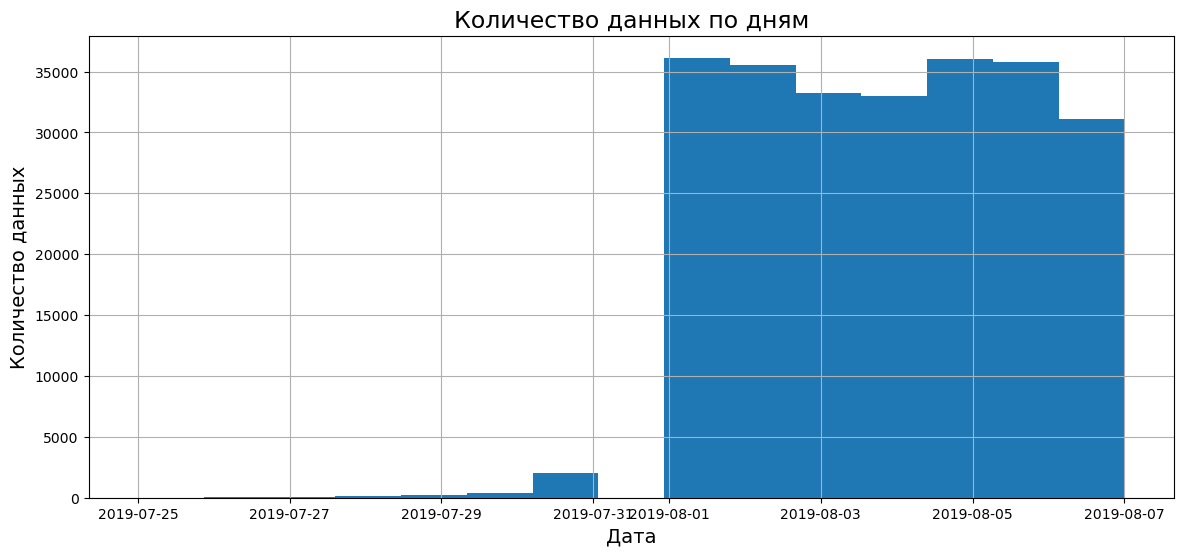

In [17]:
logs_data['event_date'].hist(bins=15, figsize=(14, 6))
plt.title('Количество данных по дням', size=17)
plt.xlabel('Дата', size=14)
plt.ylabel('Количество данных', size=14)
plt.show()

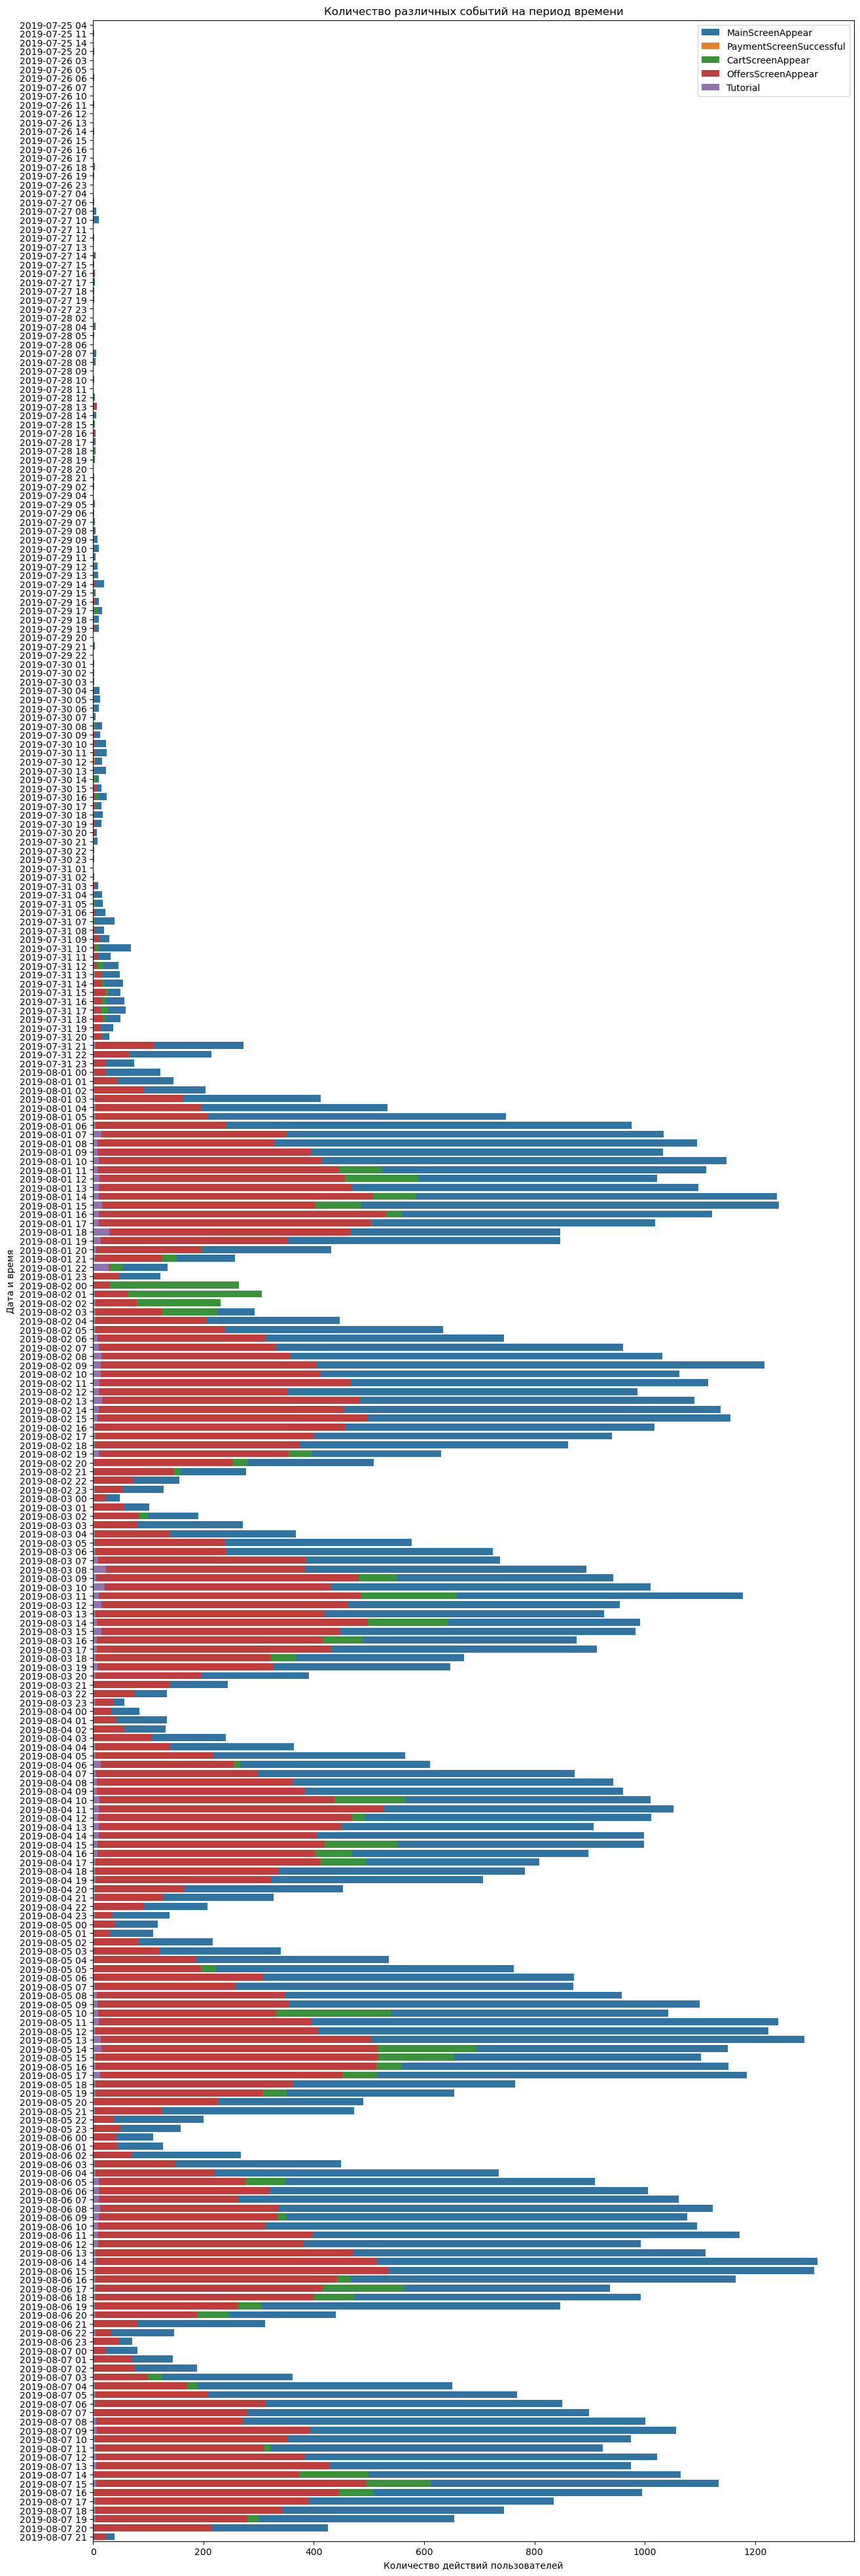

In [18]:
plt.figure(figsize=(15, 50))
ax = sns.countplot(y=logs_data['event_time'].dt.strftime('%Y-%m-%d %H'), hue='event_name', data=logs_data, dodge=False)
ax.set_title('Количество различных событий на период времени')
plt.xlabel("Количество действий пользователей")
plt.ylabel("Дата и время")
plt.legend(loc='upper right')
plt.show()

По этим двум графикам мы видим, что обладаем более полными данными за период с 21 часов 31 июля до 21 часов 7 августа. Остальные записи нужно удалить, так как наблюдений слишком мало для анализа, но они огут исказить результаты проекта.

In [19]:
logs_data_cut = logs_data.query('event_time >= "2019-07-31 21:00:00"')
logs_data_cut.head()

,event_name,user_id,event_time,group,event_date
1989,MainScreenAppear,7701922487875823903,2019-07-31 21:00:57,A2,2019-07-31
1990,MainScreenAppear,2539077412200498909,2019-07-31 21:01:45,A2,2019-07-31
1991,OffersScreenAppear,3286987355161301427,2019-07-31 21:02:21,B,2019-07-31
1992,OffersScreenAppear,3187166762535343300,2019-07-31 21:02:23,A2,2019-07-31
1993,MainScreenAppear,1118952406011435924,2019-07-31 21:03:25,B,2019-07-31


Узнаем, какую долю событий и пользователей мы потеряли, удалив неполяные данные.

In [20]:
print(f"доля потерянных событий {(len(logs_data) - len(logs_data_cut))/len(logs_data):.2%}")
print(f"доля потерянных пользователей {((logs_data['user_id'].nunique()-logs_data_cut['user_id'].nunique())/logs_data['user_id'].nunique()):.2%}")

# возможно изменилось среднее число событий на пользователя, проверяем: 
print('В среднем на пользователя приходится {} событий.'
      .format(int(logs_data_cut.groupby('user_id')['event_name'].agg('count').median())))

доля потерянных событий 0.82%
доля потерянных пользователей 0.17%
В среднем на пользователя приходится 19 событий.


Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [21]:
logs_data_cut.groupby('group')['user_id'].agg('nunique')

group
A1    2484
A2    2517
B     2537
Name: user_id, dtype: int64

**Вывод**
Мы выяснили, что полные данные имеются за период с 21 часов 31 июля до 21 часов 7 августа, то есть за неделю. Так как другая часть была неполной, мы удалили ее. При этом было потеряно 0.82% отколичества событий и 0.17% пользователей. Это действительно незначительная часть, которая не нужна при анализе.

### Построение воронки событий

#### Узнаем, какие события есть в логе, и как часто они встречаются.

In [22]:
logs_data_cut['event_name'].value_counts()

event_name
MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Tutorial                     1010
Name: count, dtype: int64

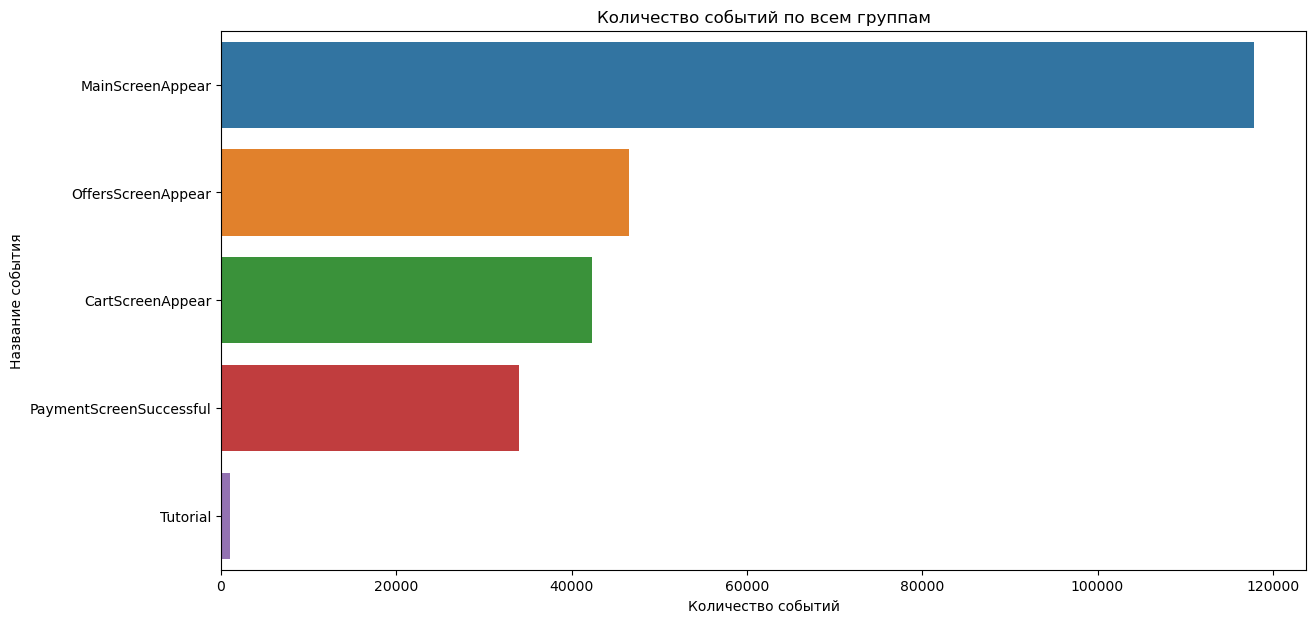

In [23]:
events = logs_data_cut.groupby('event_name')['user_id'].agg(['count', 'nunique']).reset_index()
events.columns =['event_name', 'n_events', 'n_users']
n_users = {'all': logs_data_cut['user_id'].nunique(), 
           'A1': logs_data_cut[logs_data_cut['group']=='A1']['user_id'].nunique(),
           'A2': logs_data_cut[logs_data_cut['group']=='A2']['user_id'].nunique(),
           'B': logs_data_cut[logs_data_cut['group']=='B']['user_id'].nunique(),
           'A': logs_data_cut[(logs_data_cut['group']=='A1') | (logs_data_cut['group']=='A2')]['user_id'].nunique()}

plt.figure(figsize=(14, 7))
order = events.sort_values('n_events', ascending=False).reset_index(drop=True)['event_name']
ax = sns.barplot(y='event_name', x='n_events', order = order,  data=events)
ax.set_title('Количество событий по всем группам')
plt.xlabel("Количество событий")
plt.ylabel("Название события")
plt.show()

На графике видно, что самое частое событие - открытие главной страницы, что вполне логично. По сравнению с его числом, количество события "Просмотр каталога товаров" намного меньше. Самой низкой частотой обладает событие "Руководство". Скорее всего этот этап пользователи могут пропустить, и судя по частоте события эта функция им не очень нужна. 

Теперь посмотрим, как изменяется количество событий по группам.

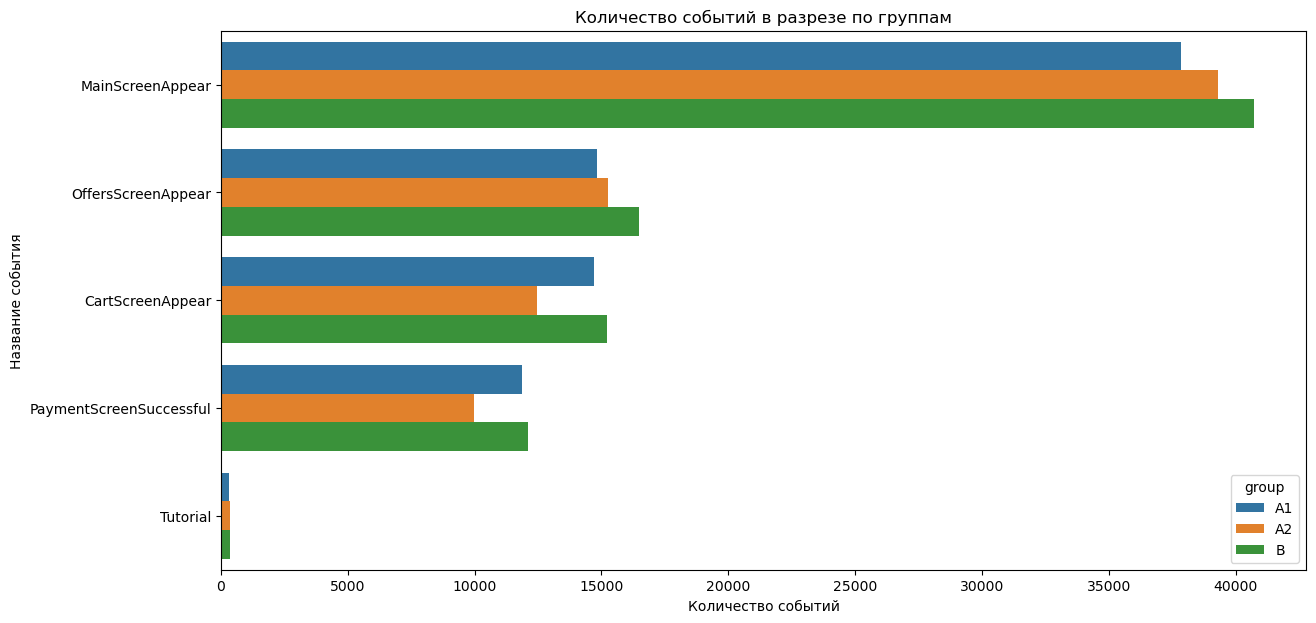

In [24]:
event_pivot=logs_data_cut.pivot_table(index=['event_name','group'], values='user_id', aggfunc=['count', 'nunique']).reset_index()
event_pivot.columns= ['event_name','group', 'n_events', 'n_users']

plt.figure(figsize=(14, 7))
ax = sns.barplot(y='event_name', x='n_events', order = order, hue='group', data=event_pivot)

ax.set_title('Количество событий в разрезе по группам')
plt.xlabel("Количество событий")
plt.ylabel("Название события")
plt.show()

Пользователи из группы А1 совершают меньше всех просмотров главной страницы и каталога. На этапе просмотра страницы корзины А2 резко теряет много человек, на следующем шаге успешной оплаты число человек из А2 тоже уменьшается сильнее, чем в других двухгруппах. В целом по количеству событий лидирует группа В. 

#### Создадим датафрейм, где посчитаем, сколько пользователей совершали каждое из  событий, а также их долю.

In [25]:
user_per_event = logs_data_cut.groupby(
    'event_name').agg({'event_name':'count', 'user_id':'nunique'}
                     ).sort_values(by='user_id', ascending=False)

user_per_event.columns = ['n_events', 'users']
user_per_event = user_per_event.reset_index()
user_per_event['users_makes_events'] = round(user_per_event['users']/logs_data_cut['user_id'].nunique() * 100, 2)
user_per_event

,event_name,n_events,users,users_makes_events
0,MainScreenAppear,117889,7423,98.47
1,OffersScreenAppear,46531,4597,60.98
2,CartScreenAppear,42343,3736,49.56
3,PaymentScreenSuccessful,33951,3540,46.96
4,Tutorial,1010,843,11.18


Построим график воронки по всем пользователям с показателями потерь и долей пользователей

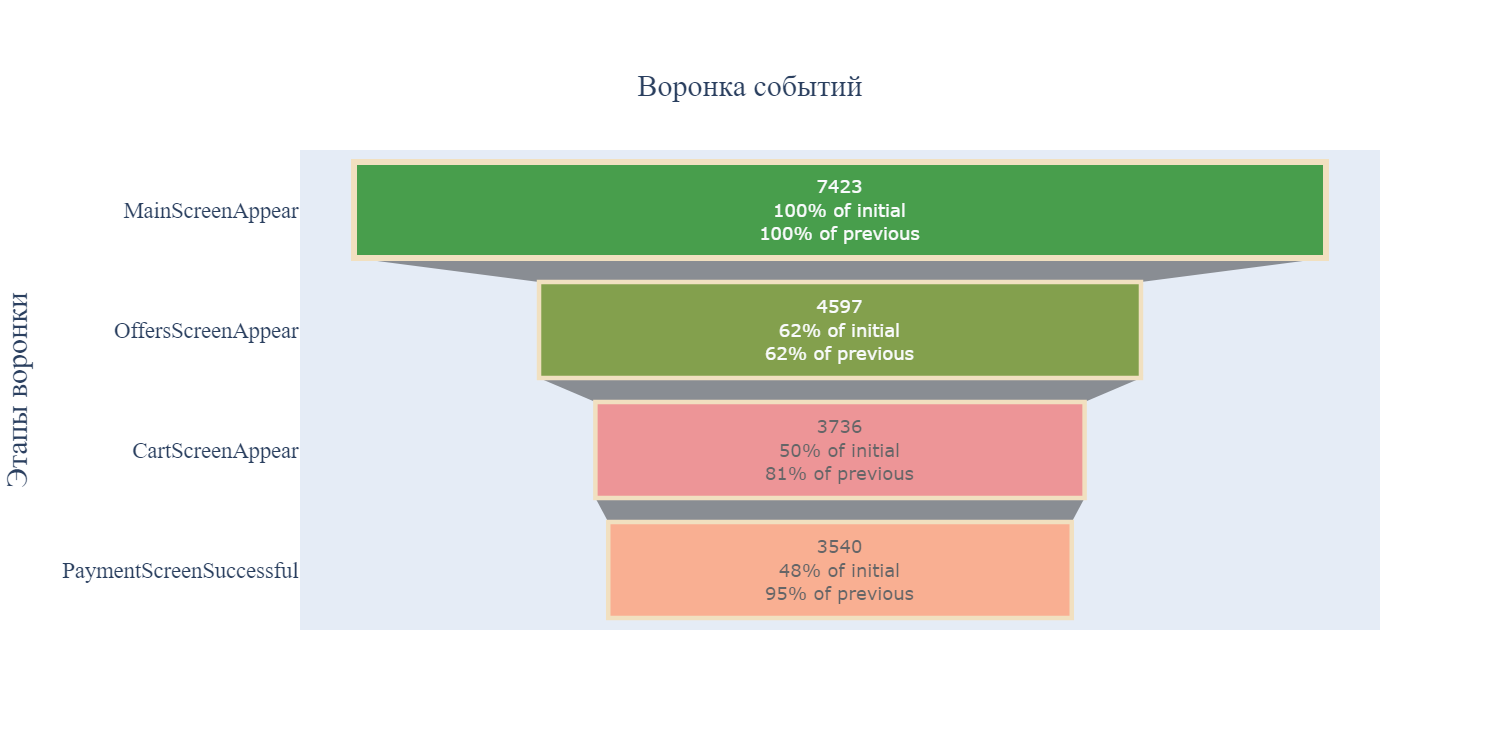

In [26]:
data_no_tutorial = user_per_event.query('event_name != "Tutorial"')

fig = go.Figure(go.Funnel(x = data_no_tutorial['users'], 
                          y = data_no_tutorial['event_name'], 
                          textinfo = "value+percent initial+percent previous",
                          opacity = 0.8, 
                          marker = {"color": ["forestgreen", "olivedrab", "lightcoral", "lightsalmon", "teal"],
                                    "line": {"width": [4, 3, 3, 3, 2, 2], 
                                             "color": ["wheat", "wheat", "wheat", "wheat", "wheat"]}}
                         )
               )
fig.update_layout(title={'text': 'Воронка событий',
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top',
                         'font':{'family':'Droid Sans', 'size':20, }},
                  yaxis_title={'text':"Этапы воронки",
                               'font':{'family':'Droid Sans', 'size':20, }},
                  yaxis={'tickfont':{'family':'Droid Sans',
                                     'size':15}},
                  autosize=False,
                  width=1000,
                  height=500)
fig.show();

По воронке можно сделать вывод о последовательности событий:

- пользователь заходит главную страницу приложения (MainScreenAppear)  
- выбирает товары в каталоге(OffersScreenAppear);
- просмотр страницы корзины(CartScreenAppear);
- оплачивает(PaymentScreenSuccessful).

Из цепочки выпадает событие Tutorial - руководство, его совершают только 11% прользователей, поэтому это действие можно исключить из анализа. 

#### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки от числа пользователей на предыдущем. 

In [27]:
data_no_tutorial = user_per_event.query('event_name != "Tutorial"')
prev_users = data_no_tutorial.loc[0,'users']
start_users = prev_users

for i in data_no_tutorial.index:
    # столбец с процентом пользователей, которые переходят на каждый последующий шаг относительно предыдущего 
    data_no_tutorial.loc[i,'prev_step'] = (data_no_tutorial.loc[i,'users'] / prev_users * 100).round(1)
    
    # столбец с процентом пользователей, которые перешли на следующий шаг, от первоначального количества 
    data_no_tutorial.loc[i,'total_per'] = (data_no_tutorial.loc[i,'users'] / start_users * 100).round(1)
    
    prev_users = data_no_tutorial.loc[i,'users']

    data_no_tutorial  

C:\Users\Polly\AppData\Local\Temp\ipykernel_11696\158738830.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Polly\AppData\Local\Temp\ipykernel_11696\158738830.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



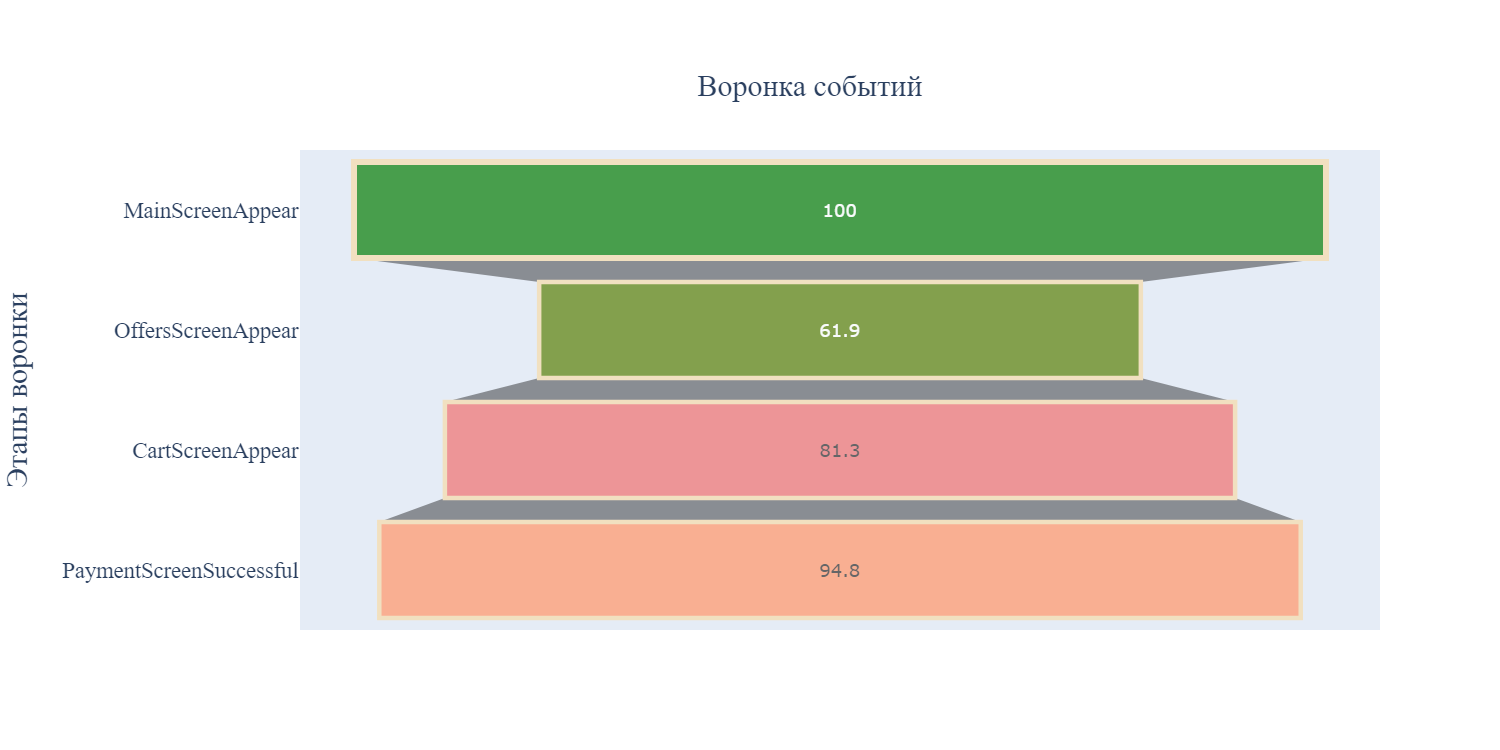

In [28]:
# строим воронку по процентам относительно предыдущего шага
fig = go.Figure(go.Funnel(x = data_no_tutorial['prev_step'], y = data_no_tutorial['event_name'],
                          opacity = 0.8,
                          marker = {"color": ["forestgreen", "olivedrab", "lightcoral", "lightsalmon", "teal"],
                                    "line": {"width": [4, 3, 3, 3, 2, 2], 
                                             "color": ["wheat", "wheat", "wheat", "wheat", "wheat"]}}))
fig.update_layout(title={'text': 'Воронка событий',
                         'y':0.9,
                         'x':0.54,
                         'xanchor': 'center',
                         'yanchor': 'top',
                         'font':{'family':'Droid Sans', 'size':20, }},
                  yaxis_title={'text':"Этапы воронки",
                               'font':{'family':'Droid Sans', 'size':20, }},
                  yaxis={'tickfont':{'family':'Droid Sans',
                                     'size':15}},
                  autosize=False,
                  width=1000,
                  height=500)
fig.show()

На графике мы видим, что наибольшая потеря пользователей происходит на шаге "Просмотр каталога". Мы делали такое преположение  по графику числа событий выше, теперь мы видим, что на втором шаге уходит почти 40% потенциальных покупателей. На мой взгляд может быть две причины такой ситуации:

1. Есть проблема при переходе с главной страницы на страницу каталога.
2. У пользователей не возникает интереса к товарам.

#### Узнаем, какая доля пользователей доходит от первого события до оплаты

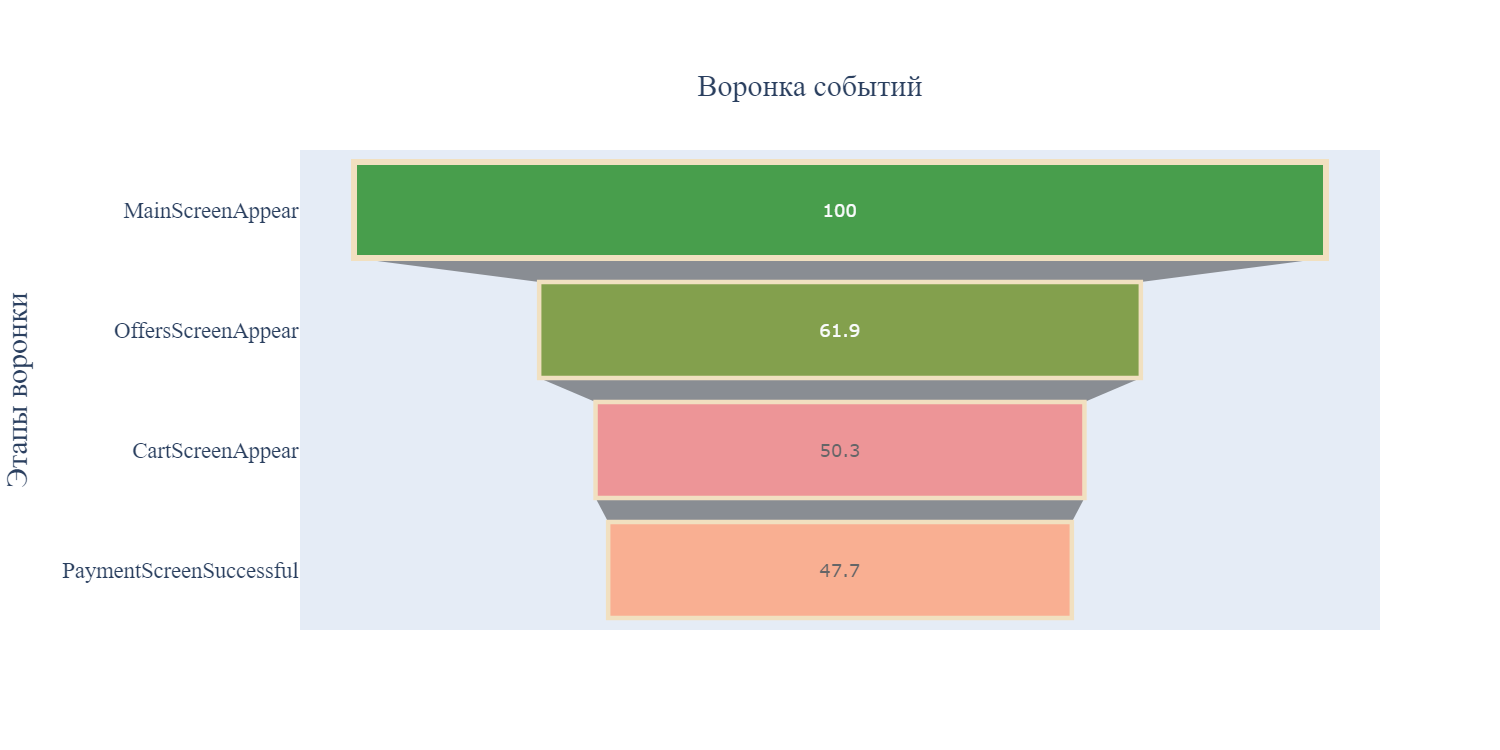

In [29]:
fig = go.Figure(go.Funnel(x = data_no_tutorial['total_per'], y = data_no_tutorial['event_name'],
                         opacity = 0.8,
                          marker = {"color": ["forestgreen", "olivedrab", "lightcoral", "lightsalmon", "teal"],
                                    "line": {"width": [4, 3, 3, 3, 2, 2], 
                                             "color": ["wheat", "wheat", "wheat", "wheat", "wheat"]}}))
fig.update_layout(title={'text': 'Воронка событий',
                         'y':0.9,
                         'x':0.54,
                         'xanchor': 'center',
                         'yanchor': 'top',
                         'font':{'family':'Droid Sans', 'size':20, }},
                  yaxis_title={'text':"Этапы воронки",
                               'font':{'family':'Droid Sans', 'size':20, }},
                  yaxis={'tickfont':{'family':'Droid Sans',
                                     'size':15}},
                  autosize=False,
                  width=1000,
                  height=500)
fig.show()

Почти 48% пользователей доходит от главной страницы до оплаты. Но это не значит, что такая же доля пользователей прошла все шаги поочередно. 

**Вывод**

Мы выяснили какие события есть в логе: просмотр главной страницы, просмотр каталога товаров, просмотр корзины, страница успешной оплаты и руководство. Посчитав частоты, оказалось, что руководство по использованию приложения часто пропускают, это событие совершили всего 11% пользователей. Оно не является обязательным элементом цепочки, поэтому мы не включили его в анализ воронки событий. По графику воронки мы узнали, что больше всего пользователей уходит на этапе просмотра страницы каталога товаров – почти 40%. От начала до конца проходит 47.7% пользователей. 

### Результаты эксперимента

#### Сколько пользователей в каждой экспериментальной группе?

In [30]:
# создаем таблицу чисденности каждой группы и суммарным числом пользователей в двух контрольных группах
users_bygroup = logs_data_cut.groupby('group')['user_id'].nunique()

# создадим столбец с суммой пользователей групп А1 и А2
users_bygroup['A1+A2'] = users_bygroup['A1'] + users_bygroup['A2']

# добавим также общую сумму пользователей
users_bygroup['all'] = users_bygroup['A1+A2'] + users_bygroup['B']

users_bygroup

group
A1       2484
A2       2517
B        2537
A1+A2    5001
all      7538
Name: user_id, dtype: int64

#### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

In [31]:
event_group_test = logs_data_cut[logs_data_cut['event_name']!='Tutorial'].pivot_table(
    index='event_name', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').sort_values(by='A1', ascending=False)

event_group_test = event_group_test.reset_index()
event_group_test['A1+A2'] = event_group_test['A1'] + event_group_test['A2']
event_group_test['all'] = event_group_test['A1+A2'] + event_group_test['B']

event_group_test['part_A1'] = (event_group_test['A1'] / users_bygroup['A1'] * 100).round(1)
event_group_test['part_A2'] = (event_group_test['A2'] / users_bygroup['A2'] * 100).round(1)
event_group_test['part_B'] = (event_group_test['B'] / users_bygroup['B'] * 100).round(1)
event_group_test['part_A1+A2'] = ((event_group_test['A1'] + event_group_test['A2']) / \
                                  (users_bygroup['A1'] + users_bygroup['A2']) * 100).round(1)
event_group_test['part_all'] = (event_group_test['all'] / users_bygroup['all'] * 100).round(1)
event_group_test

group,event_name,A1,A2,B,A1+A2,all,part_A1,part_A2,part_B,part_A1+A2,part_all
0,MainScreenAppear,2450,2479,2494,4929,7423,98.6,98.5,98.3,98.6,98.5
1,OffersScreenAppear,1542,1524,1531,3066,4597,62.1,60.5,60.3,61.3,61.0
2,CartScreenAppear,1266,1239,1231,2505,3736,51.0,49.2,48.5,50.1,49.6
3,PaymentScreenSuccessful,1200,1158,1182,2358,3540,48.3,46.0,46.6,47.2,47.0


Для проверки гипотез мы создали таблицу с количеством пользователей по группам, принявших участие в каждом действии, кроме прохождения обучения. Кроме того в дф были добавлены столбцы с отношением числа пользователей прошедших действие к общему числу пользоваетелей в группе.

Ранее мы проверили уникальность пользователей в каждой из групп и сделали вывод, что последние не пересекаются по пользователям, поэтому можно говорить о независимости выборок. Также мы вывели численность каждой группы, и делаем вывод, что выборки имеют незаначительную разницу в объеме.

Для сравнения долей групп в каждом событии будем использовать z-тест. Создадим функйию для проведения теста по каждому действию между контрольными группами.

#### А1/А2 тест

H0: между долями нет значимой разницы  
H1: между долями есть значимая разница  
Уровень статистической значимости - 0.01 Так как это является одним из условий проведения теста контрольных групп.

In [32]:
def z_test(group1, group2, alpha):
    for i in event_group_test.index:
        p1 = event_group_test[group1][i] / users_bygroup[group1]
        
        # пропорция успехов во второй группе:
        p2 = event_group_test[group2][i] / users_bygroup[group2]
        
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_group_test[group1][i] + event_group_test[group2][i]) / 
                      (users_bygroup[group1] + users_bygroup[group2]))
        
        print(event_group_test[group1][i], event_group_test[group2][i], users_bygroup[group1],users_bygroup[group2])
        
        # разница пропорций в датасетах
        difference = p1 - p2
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / math.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_bygroup[group1] + 1/users_bygroup[group2]))
        # задаем стандартное нормальное распределение 
        distr = st.norm(0, 1) 
        
        # так как распределение статистики нормальное, вызовем метод cdf()
        # саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака.
        # это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print('{} p-value: {}'.format(event_group_test['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        
z_test("A1", "A2", 0.01)

2450 2479 2484 2517
MainScreenAppear p-value: 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1542 1524 2484 2517
OffersScreenAppear p-value: 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1266 1239 2484 2517
CartScreenAppear p-value: 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1200 1158 2484 2517
PaymentScreenSuccessful p-value: 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Расчетыне показали статистически значимой разницу между долями групп А1 и А2 ytn, поэтому обе группы можно считать контрольными. Разбиение на группы работает корректно.

Перейдем к проверки гипотез с группой В.

H0: между долями нет значимой разницы  
H1: между долями есть значимая разница

Уровень статистической значимости 0.00313, так как в данном случае мы применяем поправку Бонферрони: уровень значимости для единственного стравнения делится на количество сравнений, поэтому мы разделили 0.05 на 16 и получили 0.00313.

In [33]:
z_test("A1", "B", 0.00313)

2450 2494 2484 2537
MainScreenAppear p-value: 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1542 1531 2484 2537
OffersScreenAppear p-value: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1266 1231 2484 2537
CartScreenAppear p-value: 0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1200 1182 2484 2537
PaymentScreenSuccessful p-value: 0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимой разницы в поведении пользователей групп А1 и В нет 

In [34]:
z_test("A2", "B", 0.00313)

2479 2494 2517 2537
MainScreenAppear p-value: 0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1524 1531 2517 2537
OffersScreenAppear p-value: 0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1239 1231 2517 2537
CartScreenAppear p-value: 0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

1158 1182 2517 2537
PaymentScreenSuccessful p-value: 0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимой разницы в поведении пользователей групп А2 и В нет 

In [35]:
z_test("A1+A2", "B", 0.00313)

4929 2494 5001 2537
MainScreenAppear p-value: 0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

3066 1531 5001 2537
OffersScreenAppear p-value: 0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

2505 1231 5001 2537
CartScreenAppear p-value: 0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

2358 1182 5001 2537
PaymentScreenSuccessful p-value: 0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимой разницы в поведении пользователей групп А1, А2 и В нет 

**Вывод**

Для проверки гипотез о статистически значимом различии в поведении пользователей трех групп, мы еще раз вывели численность каждой группы и сложили количество пользователей в контрольных группах, чтобы также сравнить его с помощью критерия с пользователями группы В. 
Чтобы проверить гипотезы также была написана функция и проведен А/А тест, которые не выявил статистически значимой разницы между контрольными группами. Поэтому ту же функцию мы применили для сравнения остальных пар групп. Всего было проведено 16 экспериментов. Ни в одном нулевая гипотеза об отсутствии значимой разницу между долями групп не была отвергнута. 

### Общий вывод

Итак, на протяжении всего исследования мы выяснили, что можем брать в работу данные с 2с 21 часов 31 июля до 21 часов 7 августа, то есть за неделю. Выяснили, что большинство пользователей теряется при переходе с главной страницы приложения к странице каталога товаров. Определили последовательность действий покупателей. Составили воронку покупателей по группам. Выяснили, что прохождения руководства для покупателей не является обязательным и исключили это действие из исследования. Провели 16 тестов по каждому действию мужду группами. При проведении 16 тестов значимой разницы между группами не выявлено. По итогам теста можно сказать, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Тестирование можно назвать успешным - изменение шрифта не повлияло на поведение пользователей.